# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.865559,True,8.831445
1,1.516848,True,6.905969
2,1.884270,True,8.158099
3,0.530657,True,5.441280
4,-0.327260,False,-0.780957
...,...,...,...
995,1.113405,True,8.187720
996,1.364491,True,6.718729
997,1.253218,True,5.807579
998,1.793902,True,8.316797


<Axes: xlabel='v0'>

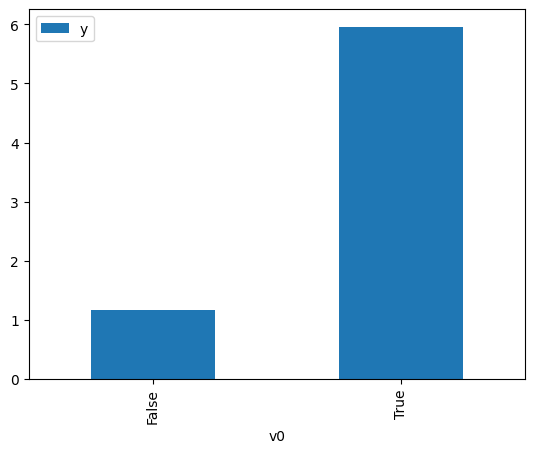

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

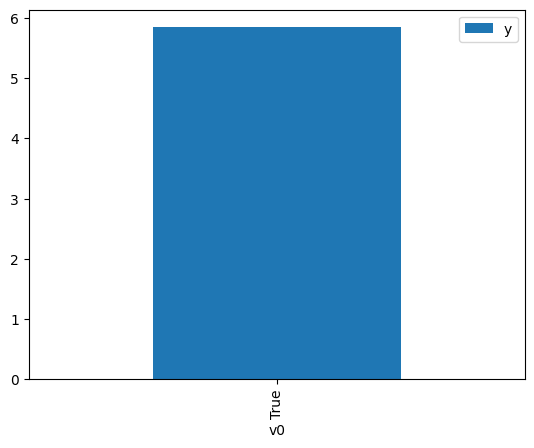

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,3.021410,False,3.740699,0.013220,75.640725
1,1.357647,False,1.156810,0.122954,8.133146
2,1.675938,False,1.706812,0.082117,12.177811
3,1.515161,False,0.898195,0.100920,9.908793
4,1.609586,False,2.389037,0.089456,11.178661
...,...,...,...,...,...
995,2.399694,False,4.652485,0.031210,32.041009
996,0.515484,False,1.975115,0.315123,3.173361
997,2.617938,False,1.587136,0.023128,43.237108
998,0.362698,False,0.887583,0.363395,2.751828


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.343228,True,7.708546,0.874835,1.143072
1,0.266791,True,3.921381,0.604754,1.653564
2,-0.165841,True,4.384875,0.453826,2.203487
3,0.468463,True,4.893656,0.670383,1.491684
4,0.416504,True,3.711377,0.653983,1.529092
...,...,...,...,...,...
995,0.083329,True,6.309776,0.541507,1.846699
996,1.970544,True,8.203722,0.944259,1.059032
997,2.289541,True,9.205801,0.963731,1.037634
998,2.508339,True,6.447556,0.973107,1.027636


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                          1.459e+04
Date:                Fri, 03 Nov 2023   Prob (F-statistic):                        0.00
Time:                        22:05:47   Log-Likelihood:                         -1410.1
No. Observations:                1000   AIC:                                      2824.
Df Residuals:                     998   BIC:                                      2834.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3898      0.037     37.880      0.000       1.318       1.462
x2             4.9342      0.053     92.930      0.000       4.830       5.038
==============================================================================
Omnibus:                        0.052   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.975   Jarque-Bera (JB):                0.095
Skew:                          -0.013   Prob(JB):                        0.954
Kurtosis:                       2.960   Cond. No.                         2.60
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""